In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

## Convolution

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


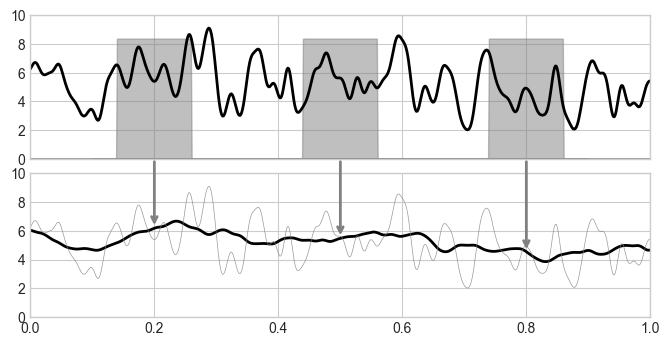

In [2]:
import numpy as np
from matplotlib import pyplot as plt


def generate_smooth_data(size, xlim=(0, 1), coeffs=(0.2, 0.3),
                         smoothing_length=0.01, rseed=0):
    """Generate a smooth random curve between 0 and 1"""
    rng = np.random.RandomState(rseed)
    x = np.linspace(*xlim, num=size)
    C = np.exp(-0.5 * (x - x[:, None]) ** 2 / smoothing_length ** 2)
    y = coeffs[0] + coeffs[1] * rng.multivariate_normal(np.zeros(len(x)), C)
    return x, y
    

x, y = generate_smooth_data(1000, rseed=5423,
                            xlim=(-0.2, 1.2),
                            coeffs=(3, 1.5),
                            smoothing_length=0.01)
y += 2 + np.sin(2 * np.pi * x)  # add larger-scale variation
w = (abs(x - 0.5) < 0.06) / 0.12  # normalized window function
y_w = np.convolve(y, w, mode='same') * (x[1] - x[0])  # convolution

fig, ax = plt.subplots(2, figsize=(8, 4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)

# Plot the data and the smoothed data
ax[0].plot(x, y, '-k', lw=2)
ax[1].plot(x, y_w, '-k', lw=2)
ax[1].plot(x, y, '-', color='gray', alpha=0.8, lw=0.5)

# Plot the window function at several locations
for window_loc in [0.2, 0.5, 0.8]:
    y_loc = y_w[np.searchsorted(x, window_loc)]
    ax[0].fill(x + window_loc - 0.5, w, color='gray', alpha=0.5)
    ax[1].annotate('', (window_loc, y_loc), (window_loc, 0.0),
                   textcoords=ax[0].transData,
                   arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax[1].yaxis.set_major_locator(plt.MultipleLocator(2))
ax[1].set(xlim=(0, 1), ylim=(0, 10))
fig.savefig('fig04_Convolution_Diagram.pdf')

## Convolution Diagram

In [3]:
def FT_plotgrid(sharex='col', sharey='col'):
    fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharex=sharex, sharey=sharey)
    fig.subplots_adjust(left=0.09, bottom=0.19, right=0.95, top=0.95)
    for axi in ax[2]:
        left, bottom, width, height = axi.get_position().bounds
        axi.set_position([left, bottom - 0.05, width, height])
    
    for axi in ax[:, 1]:
        axi.yaxis.set_major_formatter(plt.NullFormatter())

    for xcoord, text in zip([0.30, 0.77], ['$Convolution$', '$Pointwise\ Product$']):
        fig.text(xcoord, 0.42, r'$\Downarrow$',
                 size=24, ha='right', va='center')
        fig.text(xcoord + 0.01, 0.42, text,
                 size=14, ha='left', va='center')


    for ycoord in [0.28, 0.6, 0.87]:
        fig.text(0.52, ycoord, "$FT$",
                 size=14, ha='center', va='bottom')
        fig.text(0.52, ycoord, r'$\Longleftrightarrow$',
                 size=24, ha='center', va='top')
        
    return fig, ax


/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: covariance is not positive-semidefinite.


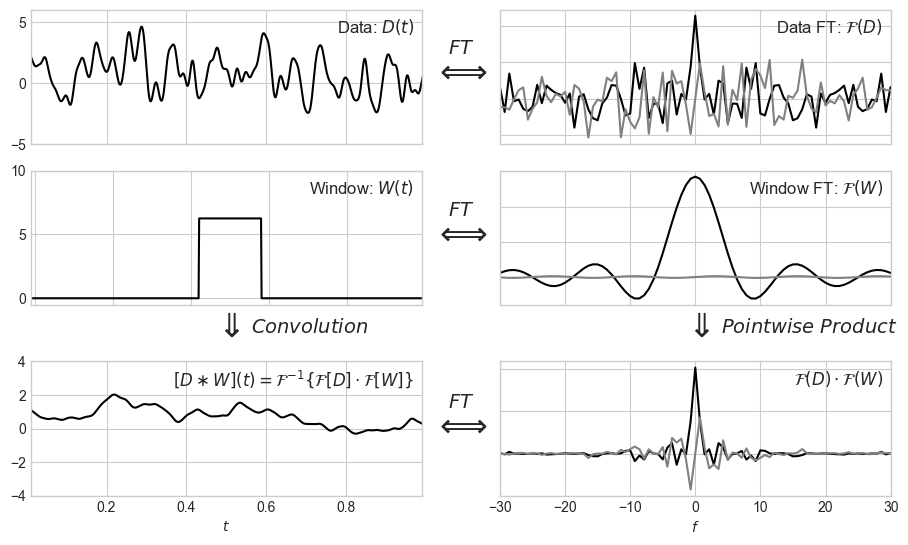

In [4]:
x, y = generate_smooth_data(1000, rseed=5423,
                            xlim=(-0.2, 1.2),
                            coeffs=(0, 1.5),
                            smoothing_length=0.01)
y += 0.5 + np.sin(2 * np.pi * x)  # add larger-scale variation
w = (abs(x - 0.5) < 0.08) / 0.16  # normalized window function
y_w = np.convolve(y, w, mode='same') * (x[1] - x[0])  # convolution

#------------------------------------------------------------
# Compute the Fourier transforms of the signal and window
# (-1)^j factors come from FFT shift (see Appendix of astroML text)
y_fft = np.fft.fft(y) * (-1) ** np.arange(len(x))
w_fft = np.fft.fft(w) * (-1) ** np.arange(len(x))
yw_fft = y_fft * w_fft

#===================================================================
# Now the plots:

def plot_ft(k, F, ax=None, legend=False, text=None):
    """plot the real and imaginary part of a Fourier transform"""
    if ax is None:
        ax = plt.gca()
    F_plot = np.fft.fftshift(F)
    ax.plot(k, F_plot.real, '-', color='black', label='real part')
    ax.plot(k, F_plot.imag, '-', color='gray', label='imag part')
    
    if legend:
        ax.legend(loc='upper left')
    if text:
        ax.text(0.98, 0.95, text, ha='right', va='top', size=12,
                transform=ax.transAxes)
    

#------------------------------------------------------------
# Set up the plots
fig, axes = FT_plotgrid(sharex=False, sharey=False)

#----------------------------------------
# Upper left panels: plot the data and window function
ax = axes[0, 0]
ax.plot(x, y, '-k')
ax.text(0.98, 0.95, r"Data: $D(t)$",
        ha='right', va='top', transform=ax.transAxes, size=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(xlim=(0.01, 0.99),
       ylim=(-5, 6))

ax = axes[1, 0]
ax.plot(x, w, '-k')
ax.text(0.98, 0.95, r"Window: $W(t)$",
        ha='right', va='top', transform=ax.transAxes, size=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(xlim=(-0.01, 0.99),
       ylim=(-0.5, 10))

#----------------------------------------
# Lower left panel: plot the convolution
ax = axes[2, 0]

ax.plot(x, y_w, '-k')

ax.text(0.98, 0.95,
        (r'$[D \ast W](t)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='right', va='top', transform=ax.transAxes, size=12)

ax.set(xlabel='$t$',
       xlim=(0.01, 0.99),
       ylim=(-4, 4))

#----------------------------------------
# Upper right panels: plot the Fourier transforms
N = len(x)
dx = (x[1] - x[0])
k = np.arange(-N/2, N/2) / N / dx

ax1 = axes[0, 1]
ax2 = axes[1, 1]

plot_ft(k, y_fft, ax=ax1, text="Data FT: " + r'$\mathcal{F}(D)$')
plot_ft(k, w_fft, ax=ax2, text="Window FT: " + r'$\mathcal{F}(W)$')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlim(-30, 30)
    

#----------------------------------------
# Lower right: plot the product of Fourier transforms
ax = axes[2, 1]
plot_ft(k, yw_fft, ax=ax,
        text=r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$')

ax.axis('tight')
ax.set(xlim=(-30, 30),
       xlabel='$f$')

ax.yaxis.set_major_formatter(plt.NullFormatter())

fig.savefig('fig05_Convolution_Theorem.pdf')